
<img src="https://raw.githubusercontent.com/MareSeestern/VineLeafDisease/master/res/titelbild.JPG" width="500" height="500">

---

# Vine Leaf Disease 

> Klassifizieren von Weinblattkrankheiten mit Künstlicher Intelligenz

> Erstellt von: Maria-Theresa Licka und Mario Schweikert

---


<p>Dokumentation unter:  <a href="https://github.com/MareSeestern/VineLeafDisease">GitHub</a></p>



Es ist zu beachten, dass wir aktuell nur eine "Lite" Version des Datensatzes öffentlich zur Verfügung stellen, aber wir zeitnah versuchen unseren deutlich größeren selbsterstellten Bilddatensatz zu veröffentlichen. Mit diesen "Lite" Datensatz, wird es natürlich nicht möglich sein, unsere Trainings-Ergebnisse zu erreichen, aber es wird vermittelt in welche Richtung es geht.
Der Datensatz kann [hier](https://www.kaggle.com/mareseestern/liteleafdisease) heruntergeladen werden.

Alle Grafiken im folgenden Notebook sind reale Grafiken, aus unserem vollwertigen Datensatz.

In [ ]:
"""
Import von: Tensorflow, Keras, Zeitmodul und ImageDataGenerator
"""

import tensorflow as tf
from tensorflow import keras
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
"""
Festlegen von Grundliegende Parameter
"""

pfad="..\data" #Pfad zu den Bilddaten
imageShape = [150,150] #Inputgröße für das Modell (optimiert auf Größe des Grafiksspeicher und Ausführbarkeit auf dem Handy)
batchSize= 100  # Größe pro Batch (optimiert auf Größe des Grafiksspeicher und Ausführbarkeit auf dem Handy))


def getData(pfad,imageShape,batchSize):
    """
    Input: 
        Pfad            String Pfad zu den Bilddaten
        imageShape      Liste Inputgröße für das Modell
        batchSize       Integer Größe pro Batch
    
    Output:
        Trainings Generator
        Validation Generator
        Trainings Generator
    """
    print("\n ----- Starte Einlesen ----- \n")
    train_datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.15, #Zoomt in das Bild
        brightness_range=[0.7, 1.4], # Verändert Helligkeit des Bildes
        fill_mode='nearest', # Legt fest, wie "neue" Bildteile gefüllt werden sollen
        vertical_flip=True,  #Dreht das Bild Vertikal
        horizontal_flip=True,# Dreht das Bild Horizontal
        rotation_range=15, # Rotiert das Bild um bis zu 359 Grad
        
        
        width_shift_range=0.1, # Verschiebung Horizontal
        height_shift_range=0.1, # Verschiebung Höhe
    
        validation_split=0.2) # Splittet 20% ab als Validation Data
    """
    Lädt .png Dateien von der Festplatte und ordnet sie der Klasse Training oder Validation zu
    """
    train_generator = train_datagen.flow_from_directory(
        pfad,
        target_size=(imageShape[0],imageShape[1]),
        batch_size=batchSize,
        class_mode='categorical',
        subset='training',
        seed=1,
        shuffle=False,
     
        ) 
    
    validation_generator = train_datagen.flow_from_directory(
        pfad, 
        target_size=(imageShape[0],imageShape[1]),
        batch_size=batchSize,
        shuffle=False,
        seed=1,
        class_mode='categorical',
        subset='validation')
    
    
    
    test_generator = None
    
 
    return train_generator,validation_generator, test_generator


Auszug aus unserem Datensatz

Echter Mehltau:

<img src="https://raw.githubusercontent.com/MareSeestern/VineLeafDisease/master/res/Echter%20Mehltau.jpg" width="500" height="500">

Falscher Mehltau:

<img src="https://raw.githubusercontent.com/MareSeestern/VineLeafDisease/master/res/Falscher%20Mehltau.JPG" width="500" height="500">

Esca:

<img src="https://raw.githubusercontent.com/MareSeestern/VineLeafDisease/master/res/Esca.jpg" width="500" height="500">

Schwarzholz:

<img src="https://raw.githubusercontent.com/MareSeestern/VineLeafDisease/master/res/Schwarzholz.jpg" width="500" height="500">

In [ ]:

def getModel(imageShape):
    """
    Input: 
        imageShape Integer
    
    Output:
        Nicht trainiertes Tensorflow Model
    """
    model = tf.keras.Sequential([
      
      keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(imageShape[0], imageShape[1],3)),

      keras.layers.MaxPooling2D(2,2),

      keras.layers.Dropout(0.5),
      
      keras.layers.Conv2D(256, (3,3), activation='relu'),
      
      keras.layers.MaxPooling2D(2,2), 
     
      keras.layers.Conv2D(512, (3,3), activation='relu'),
      
      keras.layers.MaxPooling2D(2,2),
     
      keras.layers.Flatten(),
          
      keras.layers.Dropout(0.3),      
      
      keras.layers.Dense(280, activation='relu'),
      
      keras.layers.Dense(4, activation='softmax')
    ])

    opt = tf.keras.optimizers.RMSprop()
    model.compile(loss='categorical_crossentropy',
                  optimizer= opt,
                  metrics=['accuracy'])
    
    return model



Visualisiertes Modell mit [Netron](https://lutzroeder.github.io/netron/):


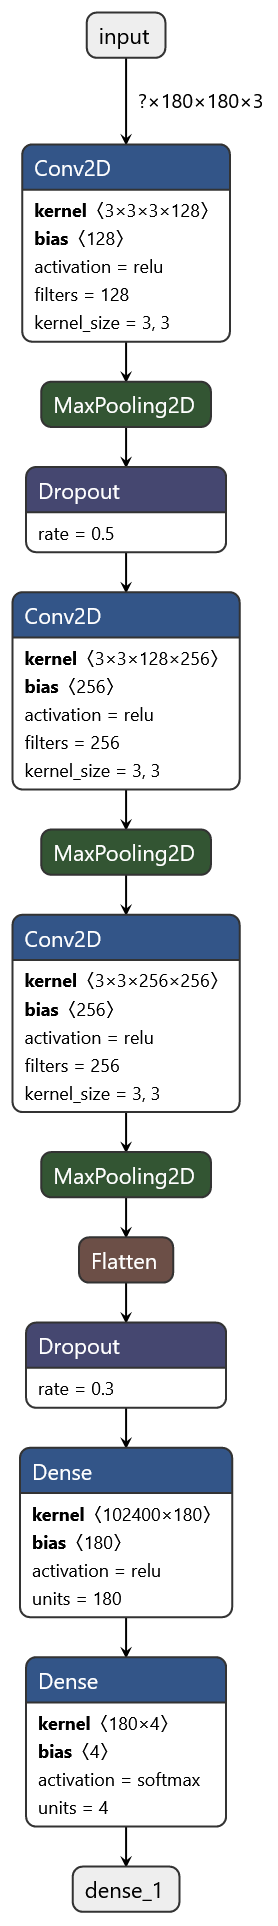

In [ ]:

def train(train_generator,validation_generator,test_generator,model,batchSize):
    """
    Input: 
        Train Generator
        Validation Generator
        Test Generator
        Nicht trainiertes Modell
        Batchsize Integer
    
    Output:
        Trainiertes Tensorflow Model
    """
    print("\n ----- Starte Training ----- \n")
    
    tensorboard = TensorBoard(log_dir='logs\\'+str(time.time()), histogram_freq=0,write_graph=True, write_images=True)
    # Tensorboard Logs zum protokollieren des Fortschrittes

    # Callbacks
    checkpoint = ModelCheckpoint("preSaved"+str(time.time())+".h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto', restore_best_weights=True)
    
    # Trainieren
    history=model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples // batchSize,
        validation_data = validation_generator, 
        validation_steps = validation_generator.samples // batchSize,
        epochs = 200,callbacks=[checkpoint,early,tensorboard],workers=-1)
    
    # Plotten der Genauigkeiten
    visualization(history)
  
   
    return model


Epochen Loss Auszug aus Tensorboard (Orange entspricht Trainings Loss und Blau Validation Loss):


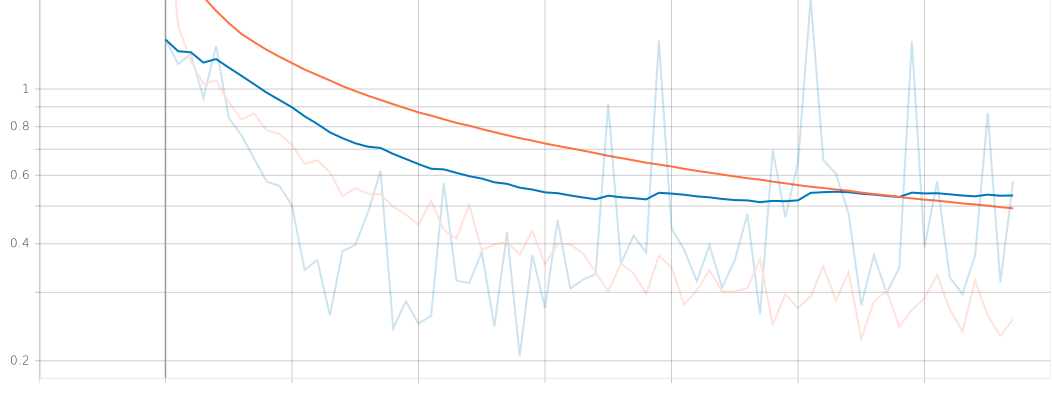


Epochen Accuracy Auszug aus Tensorboard (Orange entspricht Trainings Loss und Blau Validation Loss):


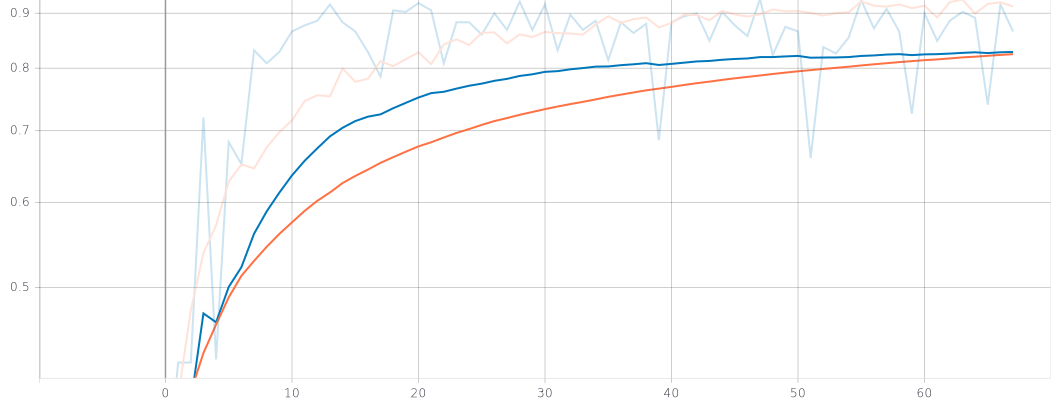

In [ ]:
def visualization(history):
    """
    Input: 
        History des trainierten Modells

    Plottet training & validation accuracy Werte direkt in Notebook (gleicher Graph wie in Tensorboard)
    """

    try:
        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
        
        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    except KeyError: # Manchmal gibt es einen Fehler Aufgrund von unterschiedlichen Tensorflow Versionen
        # Plot training & validation accuracy values
        plt.plot(history.history['acc']) # Accuracy wird zu acc
        plt.plot(history.history['val_acc'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
        
        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    

In [ ]:
def saveTrainedModel(trainedModel):
    """
    Input: 
        trainiertes Modell

    
    Speichert fertig trainiertes Modell
    """
    trainedModel.save('modelTrained.h5') 
    

In [ ]:
# Ausführen von allen Funktionen und Übersicht, was wie lange gedauert hat.

time1=time.time()

train_generator,validation_generator,test_generator=getData(pfad,imageShape,batchSize)
print("\n ----- Einlesen fertig nach: "+str(time.time()-time1)+" Sekunden ----- \n")

time2=time.time()
model=getModel(imageShape)
trainedModel=train(train_generator,validation_generator,test_generator,model,batchSize)
print("\n ----- Training fertig nach: "+str(time.time()-time2)+" Sekunden ----- \n")

saveTrainedModel(trainedModel)
print("\n ----- Modell gespeichert ----- \n")

# Testen des Modells:

In [ ]:
model = keras.models.load_model('modelTrained.h5') # Modell laden
# Erstellen eines Tests Generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        r"LeafDisease\test",
        target_size=(imageShape[0],imageShape[1]),
        batch_size=40,
        class_mode='categorical',
        shuffle=True
        )


test_generator.reset() # Bei mehrfachen ausführen wird geg. ein Fehler geworfen.
pred=model.evaluate(test_generator, steps=len(test_generator), verbose=1)


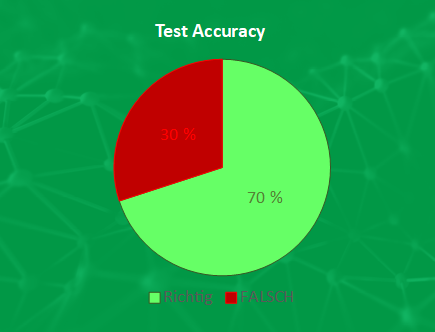

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score,accuracy_score
# Extrahieren der echten Labels aus Testgenerator

number_of_examples = len(test_generator.filenames)  
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 50)) 

test_labels = []
for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_generator[i][1]))

test_labels=np.argmax(test_labels,axis=1) # Von Hot-Encoded zu Integern


pred=model.predict(test_generator, steps=len(test_generator)) # Vorhersage
predicted_class_indices=np.argmax(pred,axis=1)  # Von Hot-Encoded zu Integern

# Ausgeben der Accuracies
print(precision_score(test_labels,predicted_class_indices,average=None)) # Klassen Accuracy ausgeben
print(accuracy_score(test_labels,predicted_class_indices)) # Gesamt Accuracy ausgeben

#Confusion Matrix erstellen
cm=confusion_matrix(test_labels,predicted_class_indices)


# Plotten der Confusion Matrix
plt.figure(figsize=(10,5))
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Echt','Esca','Falsch','Schwarzholz']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
plt.savefig('filename.png', dpi=600,)
plt.show()


Confusion Matrix:

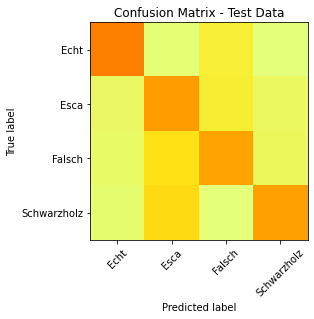

## App installieren
<p>Dazu scannen Sie diesen QR-Code mit deinem Smartphone:</p>


<img src="https://raw.githubusercontent.com/MareSeestern/VineLeafDisease/master/res/AppQR.png?token=AK7DBRV5YTJ3IDPGSTZFSK27NHMRO" width="500" height="500">


<p>oder nutzt diesen <a href="https://drive.google.com/file/d/1npnsMtaIsVVsbCF-eiqHoJnudZju3qF-/view?usp=sharing">Link</a> :</p>


Er führt zu einer .apk von Google-Drive. In naher Zukunft veröffentlichen wir unsere App auch im <strong>PlayStore</strong>

- Scannen des QR-Codes
- Auswählen des Google Accounts
- Mit Paket-Installer öffnen
- Installieren (geg. Externe-Quellen erlauben oder ähnliche Warnungen akzeptieren)
- Nach der Installation App öffnen und Zugriff auf Medien und Dateien erlauben

Durch das abfotografieren von dem Computerbildschirm kann es zu einer Verfälschung des Ergebnisses kommen.

![](https://raw.githubusercontent.com/MareSeestern/VineLeafDisease/master/res/AppTutorial.gif?token=AK7DBRSCY4MBEIMQZ6RQ62C7NHMIA)



Oder Sie schauen sich eine Demonstration unter diesm [Link](https://youtu.be/q1xcRxZ-ECc) an.
